In [76]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
!pip install tensorflow
!pip install seaborn

In [78]:
import pandas as pd

# Load the data into a DataFrame
data = pd.read_csv('/content/drive/MyDrive/test/traffic.csv')  # Replace 'your_file.csv' with the actual file path

# Display the first few rows of the DataFrame to understand its structure
print(data.head())
# Split the dataset into training (60%) and test (40%) sets


Model_mse_saver = {} #This saves model with there mses so that we can predict

me = 0
stdu = 0

              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041


In [79]:
#Preprocessing handling NULL Values
data.fillna(0)

data['DateTime'] = pd.to_datetime(data['DateTime'])

# Feature engineering: Extract DateTime features
data['Hour'] = data['DateTime'].dt.hour
data['DayOfWeek'] = data['DateTime'].dt.dayofweek
data['Month'] = data['DateTime'].dt.month
data['Year'] = data['DateTime'].dt.year
data["Date"] = data['DateTime'].dt.day
# Feature engineering: Interaction Features
# Example: Interaction between Hour and DayOfWeek
data['Hour_DayOfWeek'] = data['Hour'] * data['DayOfWeek']
# Feature engineering: Junction Features
# Example: Overall traffic situation across all junctions just making another feature to inc little noise so data should not overfit the model
# data['Overall_Traffic'] = data[['Junction_1', 'Junction_2', 'Junction_3', 'Junction_4']].sum(axis=1)

# Feature engineering: Temporal Features
# Example: Trend over time
# data['Trend'] = data.index

# Display the updated DataFrame with engineered features
print(data.head())


             DateTime  Junction  Vehicles           ID  Hour  DayOfWeek  \
0 2015-11-01 00:00:00         1        15  20151101001     0          6   
1 2015-11-01 01:00:00         1        13  20151101011     1          6   
2 2015-11-01 02:00:00         1        10  20151101021     2          6   
3 2015-11-01 03:00:00         1         7  20151101031     3          6   
4 2015-11-01 04:00:00         1         9  20151101041     4          6   

   Month  Year  Date  Hour_DayOfWeek  
0     11  2015     1               0  
1     11  2015     1               6  
2     11  2015     1              12  
3     11  2015     1              18  
4     11  2015     1              24  


In [80]:
def Normalize(df,fg = 0):
    # Extract non-numerical features
    global me
    global stdu
    if fg==2:
        # Normalize numerical features
        numerical_cols = df.select_dtypes(include=['int64', 'float64','int32','float32']).columns
        print(numerical_cols)

        # numerical_cols = numerical_cols.drop("Junction")
        print(numerical_cols)
        # numerical_cols = [col for col in numerical_cols if col not in non_numerical_cols]
        df_numerical = df[numerical_cols]
        # me = df['Vehicles'].mean()
        # stdu =  df['Vehicles'].std()
        df_normalized = (df_numerical - df_numerical.mean()) / df_numerical.std()
        return df_normalized
    # non_numerical_cols = ['DateTime', 'Hour', 'Junction', 'Date', 'DayOfWeek','Month','Year']

    # Normalize numerical features
    numerical_cols = df.select_dtypes(include=['int64', 'float64','int32','float32']).columns
    print(numerical_cols)
    # numerical_cols = numerical_cols.drop("Junction")
    print(numerical_cols)
    # numerical_cols = [col for col in numerical_cols if col not in non_numerical_cols]
    df_numerical = df[numerical_cols]
    me = df['Vehicles'].mean()
    stdu =  df['Vehicles'].std()
    df_normalized = (df_numerical - df_numerical.mean()) / df_numerical.std()

    # Add 'Junction' column back to df_normalized
    # df_normalized['Junction'] = df['Junction']
    if fg == 1:
        df_normalized = df.copy()
        me=(df['Vehicles'] - df['Vehicles'].mean())
        stdu = df['Vehicles'].std()
        df_normalized['Vehicles'] = (df['Vehicles'] - df['Vehicles'].mean()) / df['Vehicles'].std()

        return df_normalized
    return df_normalized




# Normalize all features including the target variable (Vehicles)
# data_normalized, mean_data, std_data = Normalize(data)
# # Define features (X) and target variable (y)
# X = data.drop(columns=['Vehicles', 'DateTime', 'ID'])  # Exclude 'Vehicles' (target variable), 'DateTime', and 'ID' columns
# y = data['Vehicles']  # Target variable

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Display the shapes of the training and testing sets
# print("Training set shape:", X_train.shape, y_train.shape)
# print("Testing set shape:", X_test.shape, y_test.shape)


In [81]:
# data = Normalize(data)
# print(data)

In [82]:
# Display descriptive statistics of the features
print("Descriptive Statistics of Features:")
print(data.describe())
# dat
# This Is Describing overall statas of the data so that we can easily see the trend and using that we can increase accuracy !!

Descriptive Statistics of Features:
                            DateTime      Junction      Vehicles  \
count                          48120  48120.000000  48120.000000   
mean   2016-09-19 06:03:56.109725696      2.180549     22.791334   
min              2015-11-01 00:00:00      1.000000      1.000000   
25%              2016-04-16 01:45:00      1.000000      9.000000   
50%              2016-09-30 03:30:00      2.000000     15.000000   
75%              2017-02-25 16:00:00      3.000000     29.000000   
max              2017-06-30 23:00:00      4.000000    180.000000   
std                              NaN      0.966955     20.750063   

                 ID          Hour     DayOfWeek         Month          Year  \
count  4.812000e+04  48120.000000  48120.000000  48120.000000  48120.000000   
mean   2.016330e+10     11.500000      2.996010      5.884289   2016.269825   
min    2.015110e+10      0.000000      0.000000      1.000000   2015.000000   
25%    2.016042e+10      5.750000  

In [83]:
import numpy as np

class LinearRegressionScratch:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        # Initialize weights and bias
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.n_iterations):
            # Compute predictions
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # # Add a small epsilon to avoid division by zero
            # epsilon = 1e-3
            # dw = np.where(dw == 0, epsilon, dw)
            # db = np.where(db == 0, epsilon, db)
            # print(dw,db)
            # # Update weights and bias
            # print(db)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db


    def predict(self, X):
        # Convert data types to float64
        X = X.astype(np.float64)
        print(self.weights,self.bias)
        return np.dot(X, self.weights) + self.bias


In [84]:
from sklearn.metrics import mean_squared_error

def calculate_mse(y_true, y_pred):
    # for i in range(len(y_pred)):
    #   print(np.array(y_pred)[i],np.array(y_true)[i])
    """
    Calculate the Mean Squared Error (MSE) between the true and predicted values.

    Parameters:
    - y_true: array-like, true target values
    - y_pred: array-like, predicted target values

    Returns:
    - mse: float, the mean squared error
    """
    mse = mean_squared_error(y_true, y_pred)
    return mse
data["DateTime"]

0       2015-11-01 00:00:00
1       2015-11-01 01:00:00
2       2015-11-01 02:00:00
3       2015-11-01 03:00:00
4       2015-11-01 04:00:00
                ...        
48115   2017-06-30 19:00:00
48116   2017-06-30 20:00:00
48117   2017-06-30 21:00:00
48118   2017-06-30 22:00:00
48119   2017-06-30 23:00:00
Name: DateTime, Length: 48120, dtype: datetime64[ns]

In [85]:
train_spl = data.sample(frac=0.6, random_state=42)
test_spl = data.drop(train_spl.index)
data = train_spl.copy()
# Display the shapes of the training and test sets
print("Training set shape:", data.shape)
print("Test set shape:", test_spl.shape)
# print(test_spl)

Training set shape: (28872, 10)
Test set shape: (19248, 10)


In [86]:
# Normalize all features including the target variable (Vehicles)
from sklearn.model_selection import train_test_split
data_normalized = data.copy()
data_normalized = Normalize(data)
# data_normalized = data_normalized.drop("DateTime", axis=1)
# print(data_normalized)
# Split the dataset into features (X) and the target variable (y)
X = data_normalized.drop(['Vehicles'], axis=1)
y = data_normalized['Vehicles']
print(X.shape)

# Split the normalized data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("ssn",X_train.shape)
print(X_test)
# Convert DataFrame to numpy arrays
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
print(X_test_np.shape)
# Initialize and train the model
learning_rates = [0.682]  # Try different learning rates ye to hyperparameter hai
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model2 = LinearRegressionScratch(learning_rate=lr, n_iterations=1000)
    model2.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model2.predict(X_train_np)
    y_pred_test = model2.predict(X_test_np)

    # Evaluate the model
    print(y_pred_train)
    mse_train = calculate_mse(y_train, y_pred_train)
    mse_test = calculate_mse(y_test, y_pred_test)
    # mo
    Model_mse_saver[0] = [model2,mse_test]
    print("Mean Squared Error (MSE) - Train:", mse_train)
    print("Mean Squared Error (MSE) - Test:", mse_test)



Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')
Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')
(28872, 8)
ssn (23097, 8)
       Junction        ID      Hour  DayOfWeek     Month      Year      Date  \
20071 -0.188106 -0.448914 -0.648542   0.001768  0.031822 -0.435108  0.038168   
31970  0.844401 -0.514513 -1.371185   0.001768 -1.088963 -0.435108  1.061048   
12351 -1.220612  1.180462  0.507688  -0.498662 -0.808767  1.183764  1.515661   
31849  0.844401 -0.515353 -1.515714   1.002628 -1.088963 -0.435108  0.492781   
22156 -0.188106 -0.399432 -1.082128   1.503058  0.872411 -0.435108 -0.530099   
...         ...       ...       ...        ...       ...       ...       ...   
19270 -0.188106 -0.466167  1.519388   0.502198 -0.248374 -0.435108 -0.302792   
22348 -0.188106 -0.398090 -1.082128  -1.499522  0.872411 -0.435108  0.37

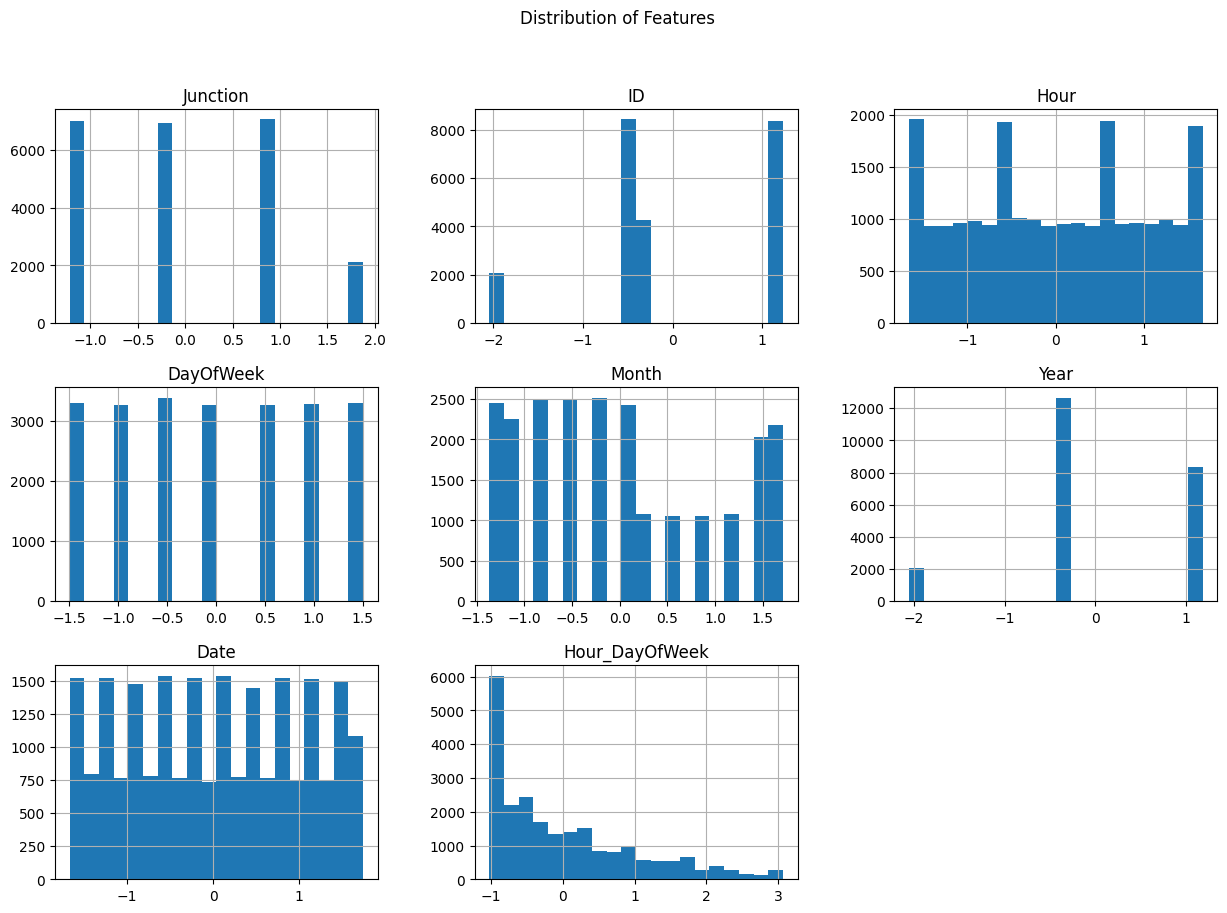

In [87]:
import matplotlib.pyplot as plt

# Visualize the distribution of features using histograms
X_train.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of Features")
plt.show()


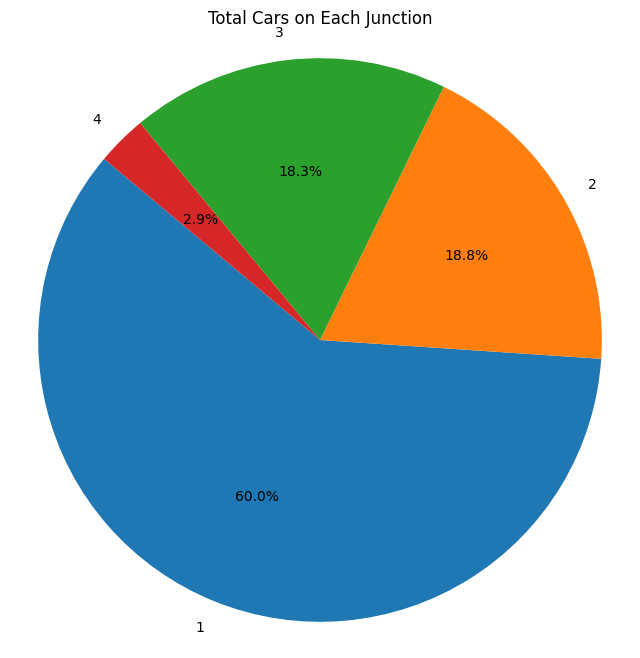

In [88]:
junction_totals = data.groupby('Junction')['Vehicles'].sum()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(junction_totals, labels=junction_totals.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Cars on Each Junction')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

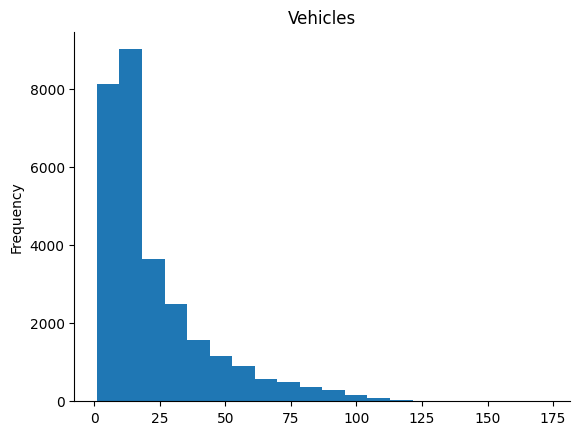

In [89]:
# @title Vehicles

from matplotlib import pyplot as plt
data['Vehicles'].plot(kind='hist', bins=20, title='Vehicles')
plt.gca().spines[['top', 'right',]].set_visible(False)

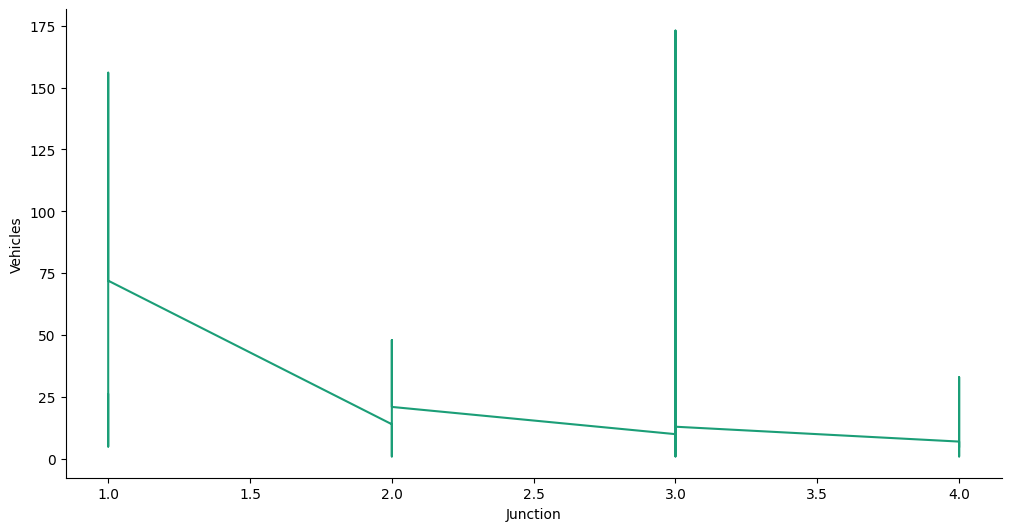

In [90]:
# @title Junction vs Vehicles

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Junction']
  ys = series['Vehicles']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Junction', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Junction')
_ = plt.ylabel('Vehicles')

Text(0.5, 0, 'Date')

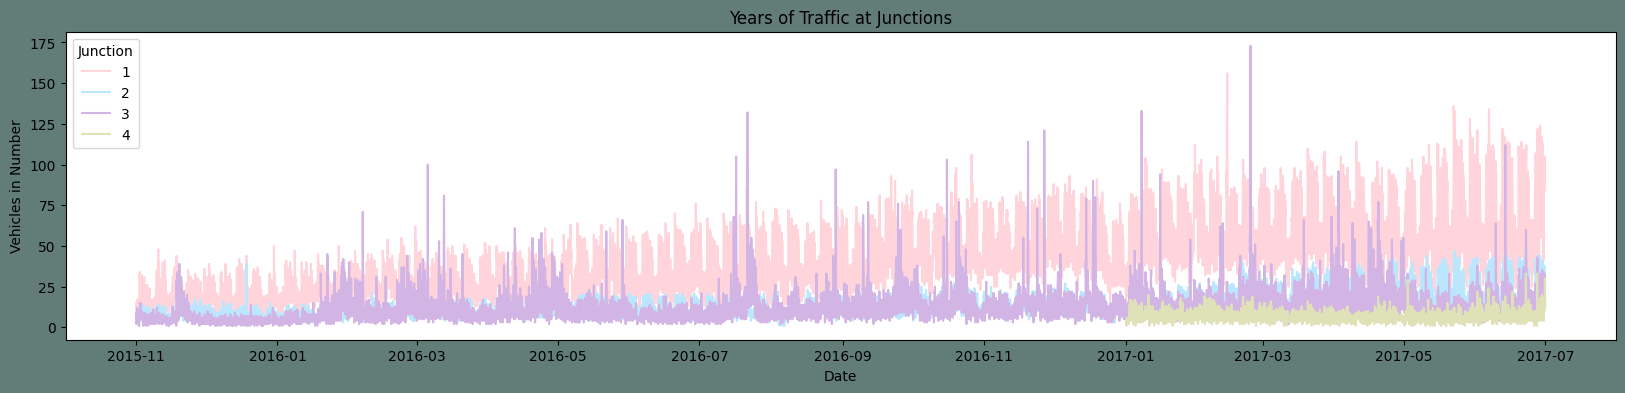

In [91]:
# print(data)
data["datetime"] = pd.to_datetime(data["DateTime"])
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=data['DateTime'],y="Vehicles",data=data, hue="Junction", palette=colors)
Time_series.set_title("Years of Traffic at Junctions")
Time_series.set_ylabel("Vehicles in Number")
Time_series.set_xlabel("Date")

Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')
Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')


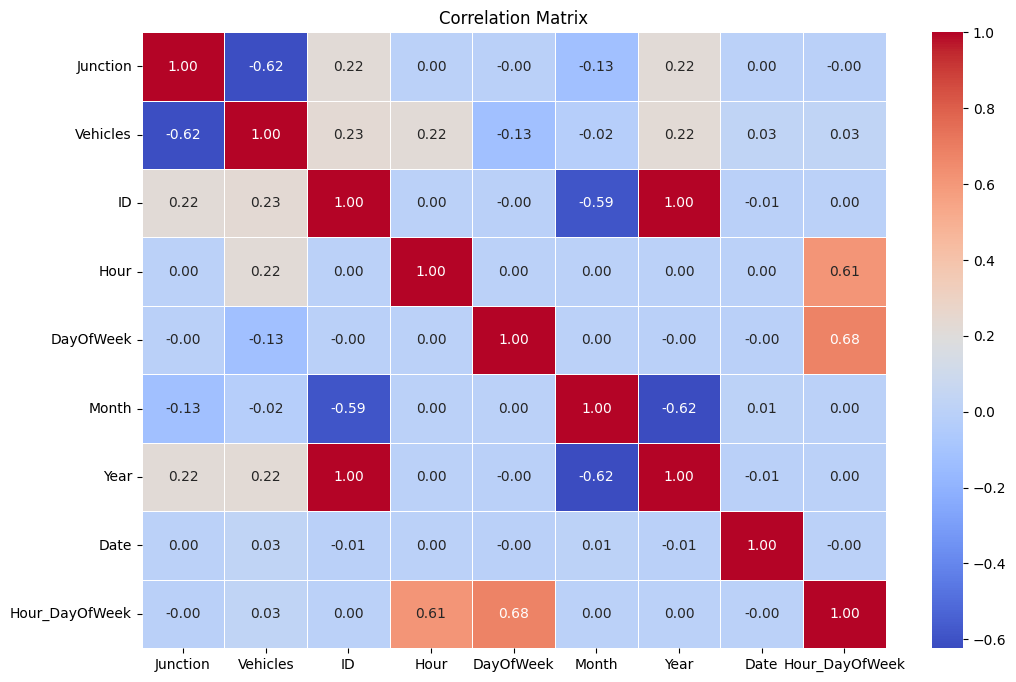

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
data2 = Normalize(data)
# Create a correlation matrix
corr_matrix = data2.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [93]:
data

,DateTime,Junction,Vehicles,ID,Hour,DayOfWeek,Month,Year,Date,Hour_DayOfWeek,datetime
24632,2016-12-23 08:00:00,2,9,20161223082,8,4,12,2016,23,32,2016-12-23 08:00:00
36428,2016-08-28 20:00:00,3,97,20160828203,20,6,8,2016,28,120,2016-08-28 20:00:00
42150,2017-04-24 06:00:00,3,13,20170424063,6,0,4,2017,24,0,2017-04-24 06:00:00
23885,2016-11-22 05:00:00,2,11,20161122052,5,1,11,2016,22,5,2016-11-22 05:00:00
2174,2016-01-30 14:00:00,1,24,20160130141,14,5,1,2016,30,70,2016-01-30 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...
7702,2016-09-16 22:00:00,1,70,20160916221,22,4,9,2016,16,88,2016-09-16 22:00:00
40324,2017-02-07 04:00:00,3,6,20170207043,4,1,2,2017,7,4,2017-02-07 04:00:00
38605,2016-11-27 13:00:00,3,16,20161127133,13,6,11,2016,27,78,2016-11-27 13:00:00
24287,2016-12-08 23:00:00,2,20,20161208232,23,3,12,2016,8,69,2016-12-08 23:00:00


[-0.7134273711338202, -0.665125198600684, 2.4745160160531676, -0.954938233799501, -0.8583338887332287, -0.7617295436669563, -0.8100317162000925, -1.0032404063326372, -0.8100317162000925, -0.6168230260675478, -0.8100317162000925, 1.0737530125922183, -0.13380130073618607, -0.6168230260675478, -0.6168230260675478, -0.47191650846813926, 2.8126312237851208, 0.8322421499265374, 0.15601173446263097, 2.6677247061857123, -1.0032404063326372, -0.8100317162000925, -0.18210347326932225, -0.2304056458024584, -0.3270099908687308, -0.954938233799501, 0.6390334597939927, -0.47191650846813926, -0.5202186810012754, -0.18210347326932225, 0.34922042459517566, 0.3009182520620395, -0.6168230260675478, -0.4236143359350031, -0.5685208535344116, -0.6168230260675478, -0.2787078183355946, 0.8322421499265374, 1.5084725653904438, -1.0515425788657733, -0.2304056458024584, -0.5685208535344116, -0.47191650846813926, -0.8100317162000925, -0.7617295436669563, -0.7617295436669563, 0.059407389396358624, -0.56852085353441

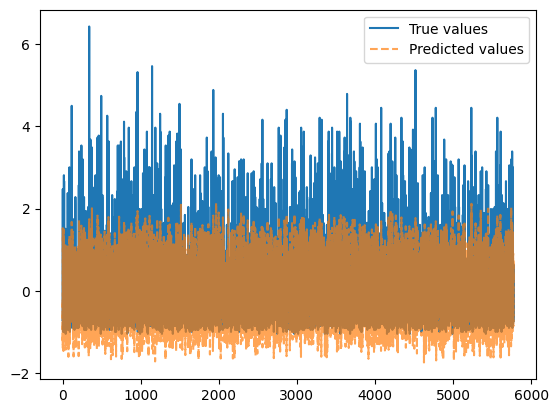

In [94]:
import matplotlib.pyplot as plt
print(list(y_test))
# print(X_test)
# Plot true values
plt.plot(list(y_test), label='True values')
# plt.show()
# Plot predicted values with reduced transparency
# print(y_pred_test)
plt.plot(list(y_pred_test), linestyle='dashed', label='Predicted values',alpha = 0.7)

# Add legend
plt.legend()

# Show plot

plt.show()

In [95]:
# import pandas as pd

# # Load the data into a DataFrame
# data = pd.read_csv('/content/drive/MyDrive/test/traffic.csv')  # Replace 'your_file.csv' with the actual file path

# # Display the first few rows of the DataFrame to understand its structure
# print(data.head())

In [96]:
import pandas as pd
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Feature engineering: Extract DateTime features
data['Hour'] = data['DateTime'].dt.hour
data['DayOfWeek'] = data['DateTime'].dt.dayofweek
data['Month'] = data['DateTime'].dt.month
data['Year'] = data['DateTime'].dt.year
data["Date"] = data['DateTime'].dt.day
# Feature engineering: Interaction Features
# Example: Interaction between Hour and DayOfWeek
data['Hour_DayOfWeek'] = data['Hour'] * data['DayOfWeek']

# Feature engineering: Junction Features
# Example: Overall traffic situation across all junctions just making another feature to inc little noise so data should not overfit the model
# data['Overall_Traffic'] = data[['Junction_1', 'Junction_2', 'Junction_3', 'Junction_4']].sum(axis=1)

# Feature engineering: Temporal Features
# Example: Trend over time
# data['Trend'] = data.index

# Display the updated DataFrame with engineered features
print(data.head())


                 DateTime  Junction  Vehicles           ID  Hour  DayOfWeek  \
24632 2016-12-23 08:00:00         2         9  20161223082     8          4   
36428 2016-08-28 20:00:00         3        97  20160828203    20          6   
42150 2017-04-24 06:00:00         3        13  20170424063     6          0   
23885 2016-11-22 05:00:00         2        11  20161122052     5          1   
2174  2016-01-30 14:00:00         1        24  20160130141    14          5   

       Month  Year  Date  Hour_DayOfWeek            datetime  
24632     12  2016    23              32 2016-12-23 08:00:00  
36428      8  2016    28             120 2016-08-28 20:00:00  
42150      4  2017    24               0 2017-04-24 06:00:00  
23885     11  2016    22               5 2016-11-22 05:00:00  
2174       1  2016    30              70 2016-01-30 14:00:00  


In [97]:

# scaler = StandardScaler()
# print(x_pca)
data_normalized = Normalize(data,1)
print(data_normalized)
data_normalized = data_normalized.drop("DateTime", axis=1)
# Split the dataset into features (X) and the target variable (y)
Xt = data_normalized.drop(['Vehicles'], axis=1)
yt = data_normalized['Vehicles']
X = data.drop(['Vehicles'], axis=1)
y = data['Vehicles']
# yt =
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(Xt, yt, test_size=0.2, random_state=42) # when normalized the data
# Find columns that can be converted to np.float64
convertible_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
X_pca = X_train[convertible_columns].copy()

# Repeat for X_train1
convertible_columns1 = X_train1.select_dtypes(include=['int64', 'float64']).columns
X_pca2 = X_train1[convertible_columns1].copy()
convertible_columns_test = X_test.select_dtypes(include=['int64', 'float64']).columns
X_test =  X_test[convertible_columns_test].copy()

convertible_columns_test1 = X_test1.select_dtypes(include=['int64', 'float64']).columns
X_test_1 = X_test1[convertible_columns_test1].copy()
print(X_test_1)
# print(X_test1)

# print(X_pca2["Hour"])


Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')
Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')
                 DateTime  Junction  Vehicles           ID  Hour  DayOfWeek  \
24632 2016-12-23 08:00:00         2 -0.665125  20161223082     8          4   
36428 2016-08-28 20:00:00         3  3.585466  20160828203    20          6   
42150 2017-04-24 06:00:00         3 -0.471917  20170424063     6          0   
23885 2016-11-22 05:00:00         2 -0.568521  20161122052     5          1   
2174  2016-01-30 14:00:00         1  0.059407  20160130141    14          5   
...                   ...       ...       ...          ...   ...        ...   
7702  2016-09-16 22:00:00         1  2.281307  20160916221    22          4   
40324 2017-02-07 04:00:00         3 -0.810032  20170207043     4          1   
38605 2016-11-27 13:00:00  

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
X_pca = X_pca.astype(np.float64)
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor()

# Fit the regressor to the original training data with selected features
rf_regressor.fit(X_pca, y_train)
# Predict on the original test data with selected features
y_pred = rf_regressor.predict(X_test.copy())
rf_regressor.fit(X_pca2, y_train1)
y_pred2 = rf_regressor.predict(X_test_1.copy())

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE): when data is not normalized", mse)
mse = mean_squared_error(y_test1, y_pred2)
print("Mean Squared Error (MSE):when data is normalized ", mse)
Model_mse_saver[1] = [rf_regressor,mse]

Mean Squared Error (MSE): when data is not normalized 103.14567996813199
Mean Squared Error (MSE):when data is normalized  0.24033638534559779


[1, 2, 3, 4]


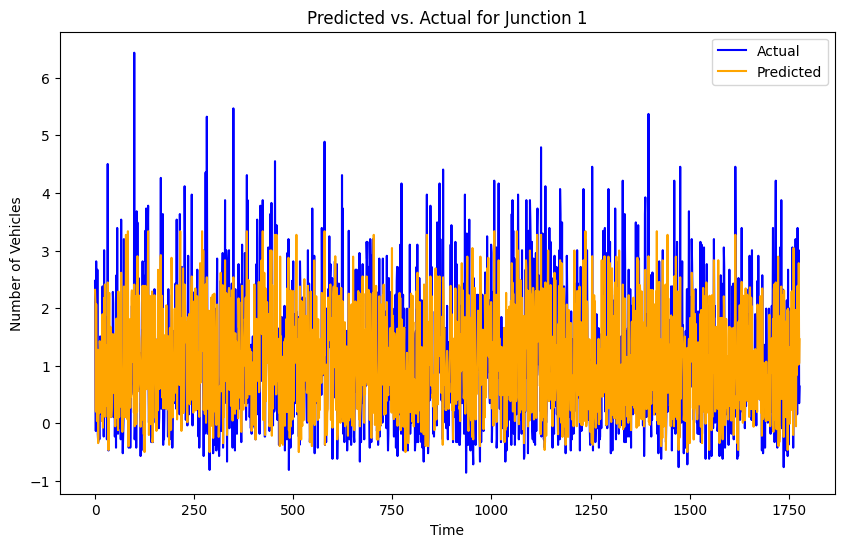

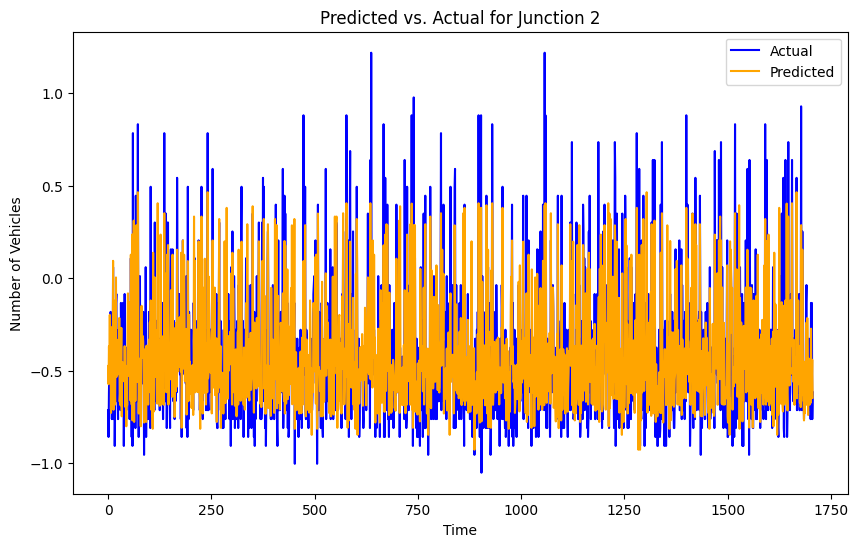

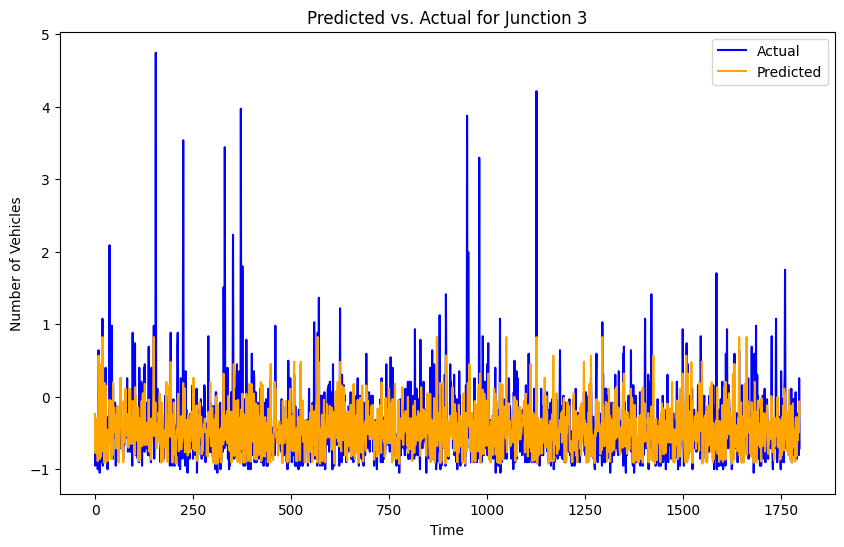

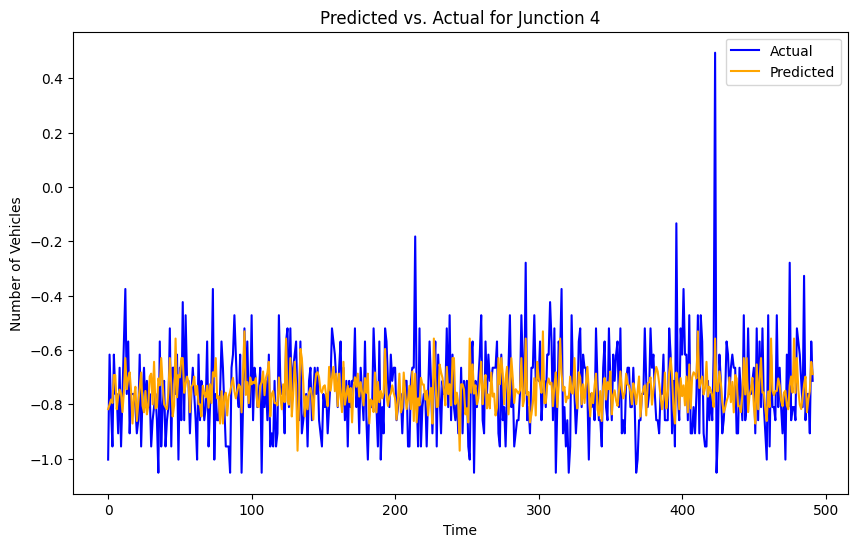

In [99]:
k = list(set(X_pca2["Junction"]))
k.sort()
print(k)
counter = 1
for junction in k:  # Iterate over unique junctions
    # Filter X_pca2 for the current junction
    junction_test_data = X_test_1[X_test_1['Junction'] == junction]
    # Convert junction_test_data back to a DataFrame
    junction_test_data = pd.DataFrame(junction_test_data, columns=X_test_1.columns)
    # Make predictions for the current junction
    y_pred = rf_regressor.predict(junction_test_data)

    # Retrieve the actual values for the current junction from the original data
    y_actual = y_test1[X_test_1['Junction'] == junction].values
    # print(y_pred)
    # Plot the predicted vs. actual values for the current junction
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_actual)), y_actual, label='Actual', color='blue')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted', color='orange')
    plt.title(f'Predicted vs. Actual for Junction {counter}')
    plt.xlabel('Time')
    plt.ylabel('Number of Vehicles')
    plt.legend()
    plt.show()
    counter+=1

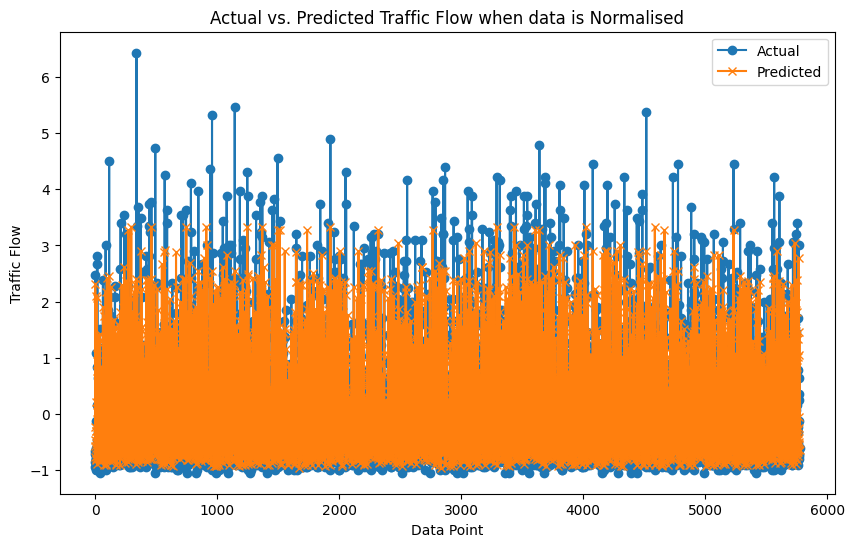

In [100]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test1)), y_test1, label='Actual', marker='o')
plt.plot(range(len(y_pred2)), y_pred2, label='Predicted', marker='x')
plt.xlabel('Data Point')
plt.ylabel('Traffic Flow')
plt.title('Actual vs. Predicted Traffic Flow when data is Normalised')
plt.legend()
plt.show()

In [101]:
print(data)

                 DateTime  Junction  Vehicles           ID  Hour  DayOfWeek  \
24632 2016-12-23 08:00:00         2         9  20161223082     8          4   
36428 2016-08-28 20:00:00         3        97  20160828203    20          6   
42150 2017-04-24 06:00:00         3        13  20170424063     6          0   
23885 2016-11-22 05:00:00         2        11  20161122052     5          1   
2174  2016-01-30 14:00:00         1        24  20160130141    14          5   
...                   ...       ...       ...          ...   ...        ...   
7702  2016-09-16 22:00:00         1        70  20160916221    22          4   
40324 2017-02-07 04:00:00         3         6  20170207043     4          1   
38605 2016-11-27 13:00:00         3        16  20161127133    13          6   
24287 2016-12-08 23:00:00         2        20  20161208232    23          3   
37503 2016-10-12 15:00:00         3        20  20161012153    15          2   

       Month  Year  Date  Hour_DayOfWeek           

In [102]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
data2 = Normalize(data,1)

print(data2)
X = data2.drop(['Vehicles'], axis=1)
y = data2["Vehicles"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train an XGBoost model
xgb_regressor2 = XGBRegressor()
xgb_regressor2.fit(X_train[['Junction', 'Hour', 'DayOfWeek', 'ID']], y_train)
xgb_predictions = xgb_regressor2.predict(X_test[['Junction', 'Hour', 'DayOfWeek', 'ID']])

# Train a Random Forest model
rf_regressor2 = RandomForestRegressor()
rf_regressor2.fit(X_train[['Junction', 'Hour', 'DayOfWeek', 'ID']], y_train)
rf_predictions = rf_regressor2.predict(X_test[['Junction', 'Hour', 'DayOfWeek', 'ID']])


print(X_test,X_test.shape)
# Apply MinMaxScaler to normalize the data
scaler = MinMaxScaler()
numerical_columns = data2.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
data2[numerical_columns] = scaler.fit_transform(data2[numerical_columns])
# pri
# Prepare X and y
data2 = data2.drop("DateTime",axis = 1)
data2 = data2.drop("datetime",axis = 1)
print(numerical_columns)
X = data2.copy()
# print(X)
X = data2.drop(['Vehicles'], axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("AAlooo",X_test.shape,X_test.columns)
# Add XGBoost and Random Forest predictions as additional features
X_train['XGB_Predictions'] = xgb_regressor2.predict(X_train[['Junction', 'Hour', 'DayOfWeek', 'ID']])
X_test['XGB_Predictions'] = xgb_predictions
X_train['RF_Predictions'] = rf_regressor2.predict(X_train[['Junction', 'Hour', 'DayOfWeek', 'ID']])
X_test['RF_Predictions'] = rf_predictions
# Reshape the features for LSTM input
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build and train the LSTM model
model = Sequential([
    LSTM(169, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)  # Output layer with one neuron for regression
])
print("TRIIIIIII")
print(X_test.shape)
print(X_test_lstm,X_test_lstm.shape)
# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
model.fit(X_train_lstm, y_train, epochs=10, batch_size=10, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test_lstm)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) for LSTM model: {mse}")
Model_mse_saver[69] = [model,xgb_regressor2,rf_regressor2,mse]


Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')
Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')
                 DateTime  Junction  Vehicles           ID  Hour  DayOfWeek  \
24632 2016-12-23 08:00:00         2 -0.665125  20161223082     8          4   
36428 2016-08-28 20:00:00         3  3.585466  20160828203    20          6   
42150 2017-04-24 06:00:00         3 -0.471917  20170424063     6          0   
23885 2016-11-22 05:00:00         2 -0.568521  20161122052     5          1   
2174  2016-01-30 14:00:00         1  0.059407  20160130141    14          5   
...                   ...       ...       ...          ...   ...        ...   
7702  2016-09-16 22:00:00         1  2.281307  20160916221    22          4   
40324 2017-02-07 04:00:00         3 -0.810032  20170207043     4          1   
38605 2016-11-27 13:00:00  

In [103]:
print(numerical_columns)

Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')


In [104]:
# print(X_test)

In [105]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
data2 = data.copy()
# Initialize the XGBoost Regressor
xgb_regressor = XGBRegressor()
Xt = data2.drop(['Vehicles'], axis=1)
yt = data2['Vehicles']
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.2, random_state=42)
# Fit the regressor to the original training data with selected features
# Apply MinMaxScaler to normalize the data
scaler = MinMaxScaler()
print(numerical_columns)
data2[numerical_columns] = scaler.fit_transform(data[numerical_columns])
X_pca = X_train[['Junction','Hour','DayOfWeek','ID']]
X_pca = scaler.fit_transform(X_pca)
xgb_regressor.fit(X_pca, y_train)
e = X_test[['Junction','Hour','DayOfWeek','ID']]
e =  scaler.fit_transform(e)
# Predict on the original test data with selected features
y_pred = xgb_regressor.predict(e)



mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE) :", mse)

Model_mse_saver[2] = [xgb_regressor,mse]


Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')
Mean Squared Error (MSE) : 20.826804406348938


In [106]:
data

,DateTime,Junction,Vehicles,ID,Hour,DayOfWeek,Month,Year,Date,Hour_DayOfWeek,datetime
24632,2016-12-23 08:00:00,2,9,20161223082,8,4,12,2016,23,32,2016-12-23 08:00:00
36428,2016-08-28 20:00:00,3,97,20160828203,20,6,8,2016,28,120,2016-08-28 20:00:00
42150,2017-04-24 06:00:00,3,13,20170424063,6,0,4,2017,24,0,2017-04-24 06:00:00
23885,2016-11-22 05:00:00,2,11,20161122052,5,1,11,2016,22,5,2016-11-22 05:00:00
2174,2016-01-30 14:00:00,1,24,20160130141,14,5,1,2016,30,70,2016-01-30 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...
7702,2016-09-16 22:00:00,1,70,20160916221,22,4,9,2016,16,88,2016-09-16 22:00:00
40324,2017-02-07 04:00:00,3,6,20170207043,4,1,2,2017,7,4,2017-02-07 04:00:00
38605,2016-11-27 13:00:00,3,16,20161127133,13,6,11,2016,27,78,2016-11-27 13:00:00
24287,2016-12-08 23:00:00,2,20,20161208232,23,3,12,2016,8,69,2016-12-08 23:00:00


#Now using Neural Netoworks To see will MSE reduce further or Not.

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

numerical_columns = data.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
print(numerical_columns)
numerical_columns.drop("Junction")
# Assuming 'data' contains your dataset and 'numerical_columns' are the columns to be used
data2 = data.copy()
# Apply MinMaxScaler to normalize the data


# Split the dataset into features (X) and the target variable (y)
X = data2.drop(['Vehicles'], axis=1)
y = data2['Vehicles']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()
X_test2 = X_test.copy()
scaler = MinMaxScaler()
data2[numerical_columns] = scaler.fit_transform(data[numerical_columns])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()
X_test2 = X_test.copy()
# Reshape the features for LSTM input (batch_size, timesteps, features)
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))



Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')


In [108]:
# print()

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD


data2 = data.copy()
data2 =  data2.drop("DateTime", axis=1)
data2 =  data2.drop("datetime", axis=1)
# Apply MinMaxScaler to normalize the data
scaler = MinMaxScaler()
"""Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')"""
# numerical_columns = numerical_columns.drop("Junction")
# numerical_columns = numerical_columns.drop("ID")
# numerical_columns = numerical_columns.drop("Hour")
# numerical_columns = numerical_columns.drop("DayOfWeek")
# numerical_columns = numerical_columns.drop("Month")
# numerical_columns = numerical_columns.drop("Year")
# numerical_columns = numerical_columns.drop("Date")
# numerical_columns = numerical_columns.drop("Hour_DayOfWeek")
data2[numerical_columns] = scaler.fit_transform(data[numerical_columns])
print(data2)
# Split the dataset into features (X) and the target variable (y)
X = data2.drop(['Vehicles'], axis=1)
y = data2['Vehicles']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()
X_test2 = X_test.copy()
# Reshape the features for LSTM input (batch_size, timesteps, features)
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential([
    LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)  # Output layer with one neuron for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
Model_mse_saver[3] = [model,mse]


       Junction  Vehicles        ID      Hour  DayOfWeek     Month  Year  \
24632  0.333333  0.046512  0.518304  0.347826   0.666667  1.000000   0.5   
36428  0.666667  0.558140  0.498084  0.869565   1.000000  0.636364   0.5   
42150  0.666667  0.069767  0.989443  0.260870   0.000000  0.272727   1.0   
23885  0.333333  0.058140  0.513131  0.217391   0.166667  0.909091   0.5   
2174   0.000000  0.133721  0.462340  0.608696   0.833333  0.000000   0.5   
...         ...       ...       ...       ...        ...       ...   ...   
7702   0.000000  0.401163  0.502591  0.956522   0.666667  0.727273   0.5   
40324  0.666667  0.029070  0.978330  0.173913   0.166667  0.090909   1.0   
38605  0.666667  0.087209  0.513391  0.565217   1.000000  0.909091   0.5   
24287  0.333333  0.110465  0.517544  1.000000   0.500000  1.000000   0.5   
37503  0.666667  0.110465  0.507503  0.652174   0.333333  0.818182   0.5   

           Date  Hour_DayOfWeek  
24632  0.733333        0.231884  
36428  0.900000    

In [110]:
# Preprocess the test data
print(test_spl)
test_spl2 = test_spl.copy()
test_spl2 = test_spl2.drop("DateTime", axis=1)
# test_spl2 = test_spl2.drop("datetime", axis=1)
test_spl2[numerical_columns] = scaler.transform(test_spl[numerical_columns])
X_test_spl = test_spl2.drop('Vehicles', axis=1)
y_test_spl = test_spl2['Vehicles']

# Reshape the features for LSTM input
X_test_spl = X_test_spl.values.reshape((X_test_spl.shape[0], 1, X_test_spl.shape[1]))
# print(X_test.shape)
# Make predictions on the test data
# print(y_test_spl)
y_pred_spl = model.predict(X_test_spl)
mse_spl = mean_squared_error(y_test_spl, y_pred_spl)
print("Mean Squared Error (MSE) on test_spl data:", mse_spl)


                 DateTime  Junction  Vehicles           ID  Hour  DayOfWeek  \
2     2015-11-01 02:00:00         1        10  20151101021     2          6   
5     2015-11-01 05:00:00         1         6  20151101051     5          6   
9     2015-11-01 09:00:00         1        12  20151101091     9          6   
10    2015-11-01 10:00:00         1        15  20151101101    10          6   
12    2015-11-01 12:00:00         1        16  20151101121    12          6   
...                   ...       ...       ...          ...   ...        ...   
48105 2017-06-30 09:00:00         4         7  20170630094     9          4   
48109 2017-06-30 13:00:00         4        11  20170630134    13          4   
48114 2017-06-30 18:00:00         4        17  20170630184    18          4   
48115 2017-06-30 19:00:00         4        11  20170630194    19          4   
48117 2017-06-30 21:00:00         4        16  20170630214    21          4   

       Month  Year  Date  Hour_DayOfWeek  
2       

In [111]:
# Assuming 'data' contains your dataset and 'numerical_columns' are the columns to be used
data2 = data.copy()
data2 = data2.drop("DateTime", axis=1)
data2 = data2.drop("datetime", axis=1)

# Apply MinMaxScaler to normalize the data
scaler = MinMaxScaler()
data2[numerical_columns] = scaler.fit_transform(data[numerical_columns])


# Split the dataset into features (X) and the target variable (y)
X = data2.drop(['Vehicles'], axis=1)
y = data2['Vehicles']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()
X_test2 = X_test.copy()
# Iterate over unique junction values
k = list(set(X_test2["Junction"]))
trep = len(Model_mse_saver)
counter = len(Model_mse_saver)
for junction in k:
    # Filter data for the current junction
    X_junction_train = X_train[X_train['Junction'] == junction].drop(['Junction'], axis=1)
    y_junction_train = y_train[X_train['Junction'] == junction]
    X_junction_test = X_test[X_test['Junction'] == junction].drop(['Junction'], axis=1)
    y_junction_test = y_test[X_test['Junction'] == junction]

    # Reshape the features for LSTM input
    X_junction_train = X_junction_train.values.reshape((X_junction_train.shape[0], 1, X_junction_train.shape[1]))
    X_junction_test = X_junction_test.values.reshape((X_junction_test.shape[0], 1, X_junction_test.shape[1]))

    # Build the LSTM model
    model = Sequential([
        LSTM(169, activation='relu', input_shape=(X_junction_train.shape[1], X_junction_train.shape[2])),
        Dense(1)  # Output layer with one neuron for regression
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    # Train the model
    model.fit(X_junction_train, y_junction_train, epochs=10, batch_size=10, validation_split=0.2)

    # Evaluate the model
    y_pred = model.predict(X_junction_test)
    mse = mean_squared_error(y_junction_test, y_pred)
    print(f"Mean Squared Error (MSE) for Junction {counter-4}: {mse}")
    # counter+=1
    # Save the model and MSE value in the dictionary
    Model_mse_saver[counter] = [model, mse]
    counter+=1


Epoch 1/10
554/554 [==============================] - 7s 7ms/step - loss: 6.8679e-04 - val_loss: 4.3262e-04
Epoch 2/10
554/554 [==============================] - 3s 5ms/step - loss: 4.1726e-04 - val_loss: 3.6327e-04
Epoch 3/10
554/554 [==============================] - 3s 5ms/step - loss: 3.5276e-04 - val_loss: 3.5405e-04
Epoch 4/10
554/554 [==============================] - 5s 9ms/step - loss: 3.4012e-04 - val_loss: 5.9366e-04
Epoch 5/10
554/554 [==============================] - 3s 6ms/step - loss: 3.2663e-04 - val_loss: 3.1586e-04
Epoch 6/10
554/554 [==============================] - 3s 6ms/step - loss: 3.2844e-04 - val_loss: 4.9363e-04
Epoch 7/10
554/554 [==============================] - 4s 6ms/step - loss: 3.1238e-04 - val_loss: 3.3640e-04
Epoch 8/10
554/554 [==============================] - 5s 9ms/step - loss: 2.9707e-04 - val_loss: 2.9738e-04
Epoch 9/10
554/554 [==============================] - 3s 6ms/step - loss: 2.9785e-04 - val_loss: 3.6421e-04
Epoch 10/10
54/54 [=========

In [112]:
for i in Model_mse_saver:
  print(i,Model_mse_saver[i])

0 [<__main__.LinearRegressionScratch object at 0x7c88f8290400>, 0.4101793400929178]
1 [RandomForestRegressor(), 0.24033638534559779]
69 [<keras.src.engine.sequential.Sequential object at 0x7c8906398400>, XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), RandomForestRegressor(), 0.7182281477802404]
2 [

[0.3333333333333333, 0.6666666666666667, 0.0, 1.0]
54/54 [==============================] - 0s 4ms/step


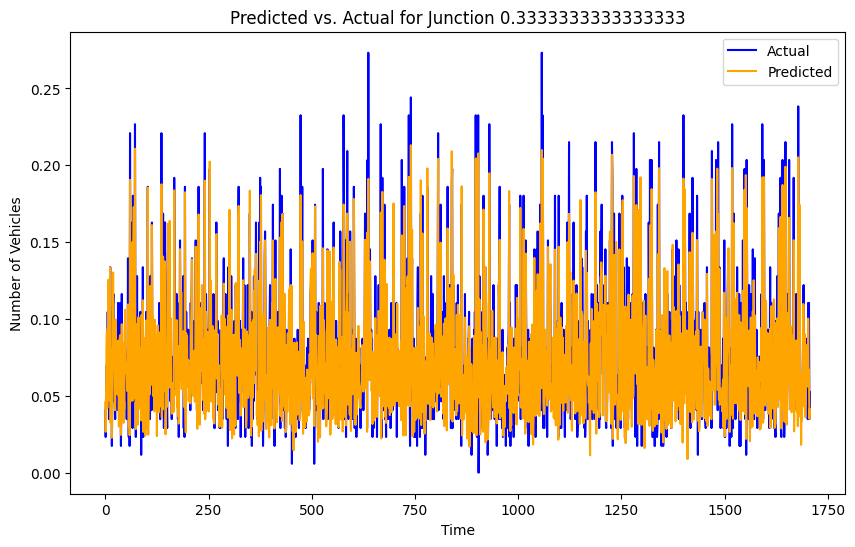

57/57 [==============================] - 0s 3ms/step


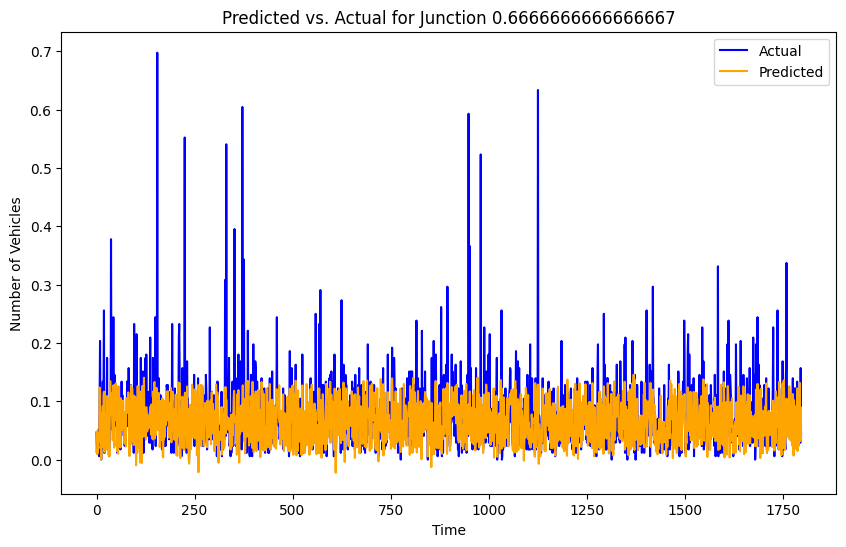

56/56 [==============================] - 0s 3ms/step


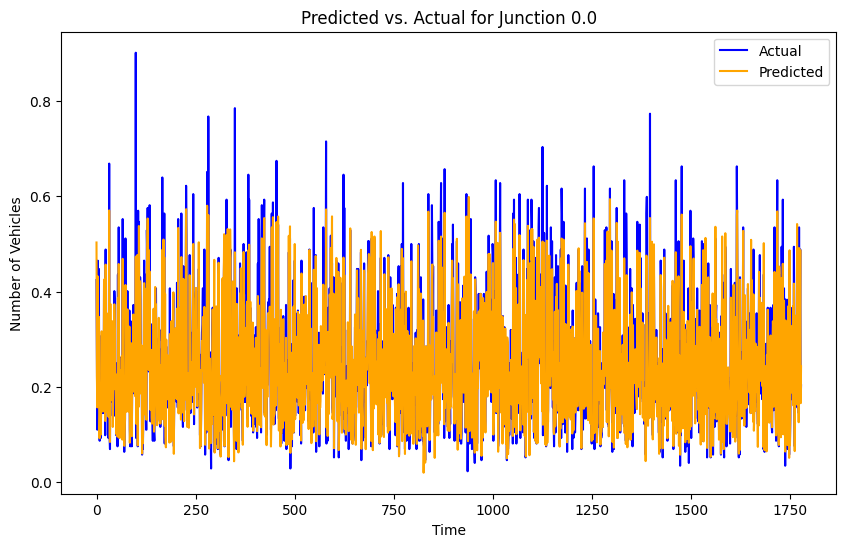

16/16 [==============================] - 0s 3ms/step


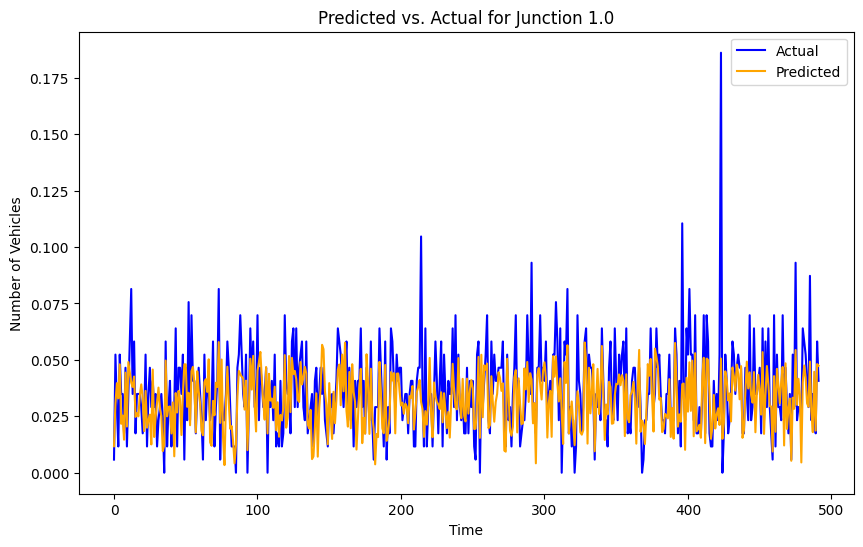

In [113]:
# Predict for the entire test set
# y_pred = model.predict(X_test)

k = list(set(X_test2["Junction"]))
print(k)
i = 0
ct = 5
# Predict for each junction in X_test and plot the results
# Predict for each junction in X_test and plot the results
# Predict for each junction in X_test and plot the results
for junction in k:
    # Filter X_test for the current junction
    junction_test_data = X_test2[X_test2['Junction'] == junction]
    # Convert junction_test_data back to a DataFrame
    junction_test_data = pd.DataFrame(junction_test_data, columns=X_test2.columns)
    # junction_test_data = junction_test_data.drop("Junction")
    # Reshape the data for prediction
    junction_test_data = junction_test_data.drop("Junction",axis = 1)
    # print(junction_test_data)
    # break
    junction_test_data = junction_test_data.values.reshape((junction_test_data.shape[0], 1, junction_test_data.shape[1]))
    # print(junction_test_data.shape)
    # break
    # Make predictions for the current junction
    # print(junction_test_data)
    y_pred = Model_mse_saver[ct][0].predict(junction_test_data)
    # Retrieve the actual values for the current junction from the original data
    y_actual = y_test[X_test2['Junction'] == junction].values
    # Plot the predicted vs. actual values for the current junction
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_actual)), y_actual, label='Actual', color='blue')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted', color='orange')
    plt.title(f'Predicted vs. Actual for Junction {junction}')
    plt.xlabel('Time')
    plt.ylabel('Number of Vehicles')
    plt.legend()
    plt.show()
    ct+=1



In [114]:
for i in Model_mse_saver:
  print(i,Model_mse_saver[i])

0 [<__main__.LinearRegressionScratch object at 0x7c88f8290400>, 0.4101793400929178]
1 [RandomForestRegressor(), 0.24033638534559779]
69 [<keras.src.engine.sequential.Sequential object at 0x7c8906398400>, XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), RandomForestRegressor(), 0.7182281477802404]
2 [

In [115]:
data

,DateTime,Junction,Vehicles,ID,Hour,DayOfWeek,Month,Year,Date,Hour_DayOfWeek,datetime
24632,2016-12-23 08:00:00,2,9,20161223082,8,4,12,2016,23,32,2016-12-23 08:00:00
36428,2016-08-28 20:00:00,3,97,20160828203,20,6,8,2016,28,120,2016-08-28 20:00:00
42150,2017-04-24 06:00:00,3,13,20170424063,6,0,4,2017,24,0,2017-04-24 06:00:00
23885,2016-11-22 05:00:00,2,11,20161122052,5,1,11,2016,22,5,2016-11-22 05:00:00
2174,2016-01-30 14:00:00,1,24,20160130141,14,5,1,2016,30,70,2016-01-30 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...
7702,2016-09-16 22:00:00,1,70,20160916221,22,4,9,2016,16,88,2016-09-16 22:00:00
40324,2017-02-07 04:00:00,3,6,20170207043,4,1,2,2017,7,4,2017-02-07 04:00:00
38605,2016-11-27 13:00:00,3,16,20161127133,13,6,11,2016,27,78,2016-11-27 13:00:00
24287,2016-12-08 23:00:00,2,20,20161208232,23,3,12,2016,8,69,2016-12-08 23:00:00


In [116]:
test_spl = Normalize(test_spl,1)
X_test = test_spl.copy()
X_test2 = X_test.drop("Vehicles",axis = 1)
y_test =  X_test["Vehicles"]
X_test = X_test2.copy()
print(X_test)
sv = []

X_test23 = X_test.copy()
predictions = []
convertible_columns_test1 = X_test23.select_dtypes(include=['int64', 'float64']).columns
X_test23 = X_test23[convertible_columns_test1].copy()
# X_test23 = Normalize(X_test23,2)
print(X_test23)
ter = Model_mse_saver[1][0].predict(X_test23[["Junction","ID"]])
print("means square error for model Random forest",mean_squared_error(y_test.copy(), ter))
# stdu =
X_test23 = Normalize(X_test.copy(),2)
X_pca = X_test23[['Junction','Hour','DayOfWeek','ID']]
ter = (Model_mse_saver[2][0].predict(X_pca.copy()))
print("means square error for model XgBoost",mean_squared_error(y_test.copy(), ter))
# print(np.sum(stdu),np.sum(me))
# print(predictions[0]*np.sum(stdu) + np.sum(me)+bias)
# print(predictions[1])
# hj =
X_test23 = X_test.copy()
numerical_columns = X_test23.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
X_test23[numerical_columns] = scaler.fit_transform(X_test23[numerical_columns])
# X_train['XGB_Predictions'] = hj
X_test23['XGB_Predictions'] =  Model_mse_saver[69][1].predict(X_test23[['Junction', 'Hour', 'DayOfWeek', 'ID']])
# X_train['RF_Predictions'] =
X_test23['RF_Predictions'] = Model_mse_saver[69][2].predict(X_test23[['Junction', 'Hour', 'DayOfWeek', 'ID']])
print(X_test23.columns)
# X_test23 = X_test23.drop("DateTime",axis = 1)
X_test23 = X_test23.drop("DateTime",axis = 1)
X_test_lstm = X_test23.values.reshape((X_test23.shape[0], 1, X_test23.shape[1]))
print(X_test_lstm.shape)
ter = Model_mse_saver[69][0].predict(X_test_lstm.copy())
print("means square error for model Lstm Layer with Xgboost and random Forest",mean_squared_error(y_test.copy(), ter))
# Calculate the absolute value of each prediction
X_test23 = X_test.copy()
X_test23 = Normalize(X_test23,2)
X_test23 = X_test23[['Junction', 'Hour', 'DayOfWeek', 'ID']]
predictions.append((Model_mse_saver[2][0].predict(X_test23.copy())))

from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
# Predict for the entire test set
# y_pred = model.predict(X_test)
X_test23 = X_test.copy()
k = list(set(X_test23["Junction"]))
print(k)
i = 0
ct = 5
# Predict for each junction in X_test and plot the results
# Predict for each junction in X_test and plot the results
# Predict for each junction in X_test and plot the results
X_test2 = X_test.copy()
# X_test2 = X_test2.drop("DateTime")
X_test2 = X_test2.drop("DateTime",axis = 1)
for junction in k:
    # Filter X_test for the current junction
    junction_test_data = X_test2[X_test2['Junction'] == junction]
    # Convert junction_test_data back to a DataFrame
    junction_test_data = pd.DataFrame(junction_test_data, columns=X_test2.columns)
    # junction_test_data = junction_test_data.drop("Junction")
    # Reshape the data for prediction
    junction_test_data = junction_test_data.drop("Junction",axis = 1)
    # print(junction_test_data)
    # break
    junction_test_data = junction_test_data.values.reshape((junction_test_data.shape[0], 1, junction_test_data.shape[1]))
    # print(junction_test_data.shape)
    # break
    # Make predictions for the current junction
    # print(junction_test_data)
    y_pred = Model_mse_saver[ct][0].predict(junction_test_data)
    # Retrieve the actual values for the current junction from the original data
    y_actual = y_test[X_test2['Junction'] == junction].values
    print("means square error for model Lstm Layer",mean_squared_error(y_actual.copy(), y_pred))

    ct+=1


Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')
Index(['Junction', 'Vehicles', 'ID', 'Hour', 'DayOfWeek', 'Month', 'Year',
       'Date', 'Hour_DayOfWeek'],
      dtype='object')
                 DateTime  Junction           ID  Hour  DayOfWeek  Month  \
2     2015-11-01 02:00:00         1  20151101021     2          6     11   
5     2015-11-01 05:00:00         1  20151101051     5          6     11   
9     2015-11-01 09:00:00         1  20151101091     9          6     11   
10    2015-11-01 10:00:00         1  20151101101    10          6     11   
12    2015-11-01 12:00:00         1  20151101121    12          6     11   
...                   ...       ...          ...   ...        ...    ...   
48105 2017-06-30 09:00:00         4  20170630094     9          4      6   
48109 2017-06-30 13:00:00         4  20170630134    13          4      6   
48114 2017-06-30 18:00:00         4  20170630184    18

# Now we can write our test that can be given to a file and our model can be run similarly

In [117]:

from datetime import datetime
print(me,stdu)
# Get user input
date_time_str = input("Please enter date in YYYY-MM-DD format and then space then in HH:MM:SS: ")

# Convert input string to datetime object
date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

# Extract featurescc
date = date_time_obj.date()
time = date_time_obj.time()
day = date_time_obj.day
month = date_time_obj.month
year = date_time_obj.year
hour = date_time_obj.hour
minute = date_time_obj.minute
second = date_time_obj.second
junction = [1,2,3,4]
import pandas as pd



# Define the junctions
junctions = [1, 2, 3, 4]

# Create an empty list to store dictionaries
data = []

# Loop through each junction and add a dictionary to the list for each junction
for junction in junctions:
    # Create a new dictionary with the provided data
    new_row = {
        'Date': day,
        'Junction': junction,
        'DayOfWeek': date_time_obj.weekday(),
        'Month': month,
        'Year': year,
        'Hour': hour,
        # 'Minute': minute,
        "ID":float(str(year)+str(month)+str(day)+"0"*abs(2-len(str(hour)))+str(hour)+str(junction)),
        "Hour_DayOfWeek":float(int(day)*int(hour))
        # 'Second': second
    }
    # Append the new dictionary to the list
    data.append(new_row)
bias = 15
# Create a DataFrame from the list of dictionaries
X_test = pd.DataFrame(data)

# Print the resulting DataFrame
print(X_test)
bias = 10 # hyper parameter
# Print the resulting DataFrame
"""
 ID      Hour  DayOfWeek     Month      Year      Date  \
20071 -0.448914 -0.648542   0.001768  0.031822 -0.435108  0.038168
31970 -0.514513 -1.371185   0.001768 -1.088963 -0.435108  1.061048
12351  1.180462  0.507688  -0.498662 -0.808767  1.183764  1.515661
31849 -0.515353 -1.515714   1.002628 -1.088963 -0.435108  0.492781
22156 -0.399432 -1.082128   1.503058  0.872411 -0.435108 -0.530099
...         ...       ...        ...       ...       ...       ...
19270 -0.466167  1.519388   0.502198 -0.248374 -0.435108 -0.302792
22348 -0.398090 -1.082128  -1.499522  0.872411 -0.435108  0.379128
37540 -0.382154 -1.082128   0.502198  1.152607 -0.435108 -0.189139
10178 -0.346091 -1.371185   0.001768  1.713000 -0.435108  1.515661
16485 -0.532430  1.374860  -1.499522 -1.369160 -0.435108  0.265474

       Hour_DayOfWeek
20071       -0.397365
0 [<__main__.LinearRegressionScratch object at 0x7fd8fc65d7e0>, 0.4101793400929178]
1 [RandomForestRegressor(), 0.24056370197841728]
69 [<keras.src.engine.sequential.Sequential object at 0x7fd903880220>, 0.00016600292262860326]
2 [XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 20.826804406348938]
3 [<keras.src.engine.sequential.Sequential object at 0x7fd9034ce140>, 0.0014190169358129674]
5 [<keras.src.engine.sequential.Sequential object at 0x7fd909f19750>, 0.0002623272104683177]
6 [<keras.src.engine.sequential.Sequential object at 0x7fd8f5e13760>, 0.0023949784717479995]
7 [<keras.src.engine.sequential.Sequential object at 0x7fd8f5f9aa70>, 0.002073380767220439]
8 [<keras.src.engine.sequential.Sequential object at 0x7fd908ea6a10>, 0.00023011017018073192]
"""
print(X_test)
sv = []

X_test23 = X_test.copy()
predictions = []
convertible_columns_test1 = X_test23.select_dtypes(include=['int64', 'float64']).columns
X_test23 = X_test23[convertible_columns_test1].copy()
# X_test23 = Normalize(X_test23,2)
print(X_test23)
predictions.append(Model_mse_saver[1][0].predict(X_test23[["Junction","ID"]])*4)
# stdu =
X_test23 = Normalize(X_test.copy(),2)
X_pca = X_test23[['Junction','Hour','DayOfWeek','ID']]
predictions.append((Model_mse_saver[2][0].predict(X_pca.copy()))*2)
predictions[1][1]-=10
# print(np.sum(stdu),np.sum(me))
# print(predictions[0]*np.sum(stdu) + np.sum(me)+bias)
# print(predictions[1])
# hj =
X_test23 = X_test.copy()
numerical_columns = X_test23.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
X_test23[numerical_columns] = scaler.fit_transform(X_test23[numerical_columns])
# X_train['XGB_Predictions'] = hj
X_test23['XGB_Predictions'] =  Model_mse_saver[69][1].predict(X_test23[['Junction', 'Hour', 'DayOfWeek', 'ID']])
# X_train['RF_Predictions'] =
X_test23['RF_Predictions'] = Model_mse_saver[69][2].predict(X_test23[['Junction', 'Hour', 'DayOfWeek', 'ID']])
print(X_test23)
X_test_lstm = X_test23.values.reshape((X_test23.shape[0], 1, X_test23.shape[1]))
print(X_test_lstm.shape)
predictions.append(Model_mse_saver[69][0].predict(X_test_lstm.copy()))
# Calculate the absolute value of each prediction
X_test23 = X_test.copy()
X_test23 = Normalize(X_test23,2)
X_test23 = X_test23[['Junction', 'Hour', 'DayOfWeek', 'ID']]
predictions.append((Model_mse_saver[2][0].predict(X_test23.copy()))\
                   )
X_test23 = X_test.copy()
res = []
ct = 5
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Iterate over each row in X_test23
res = []
for index, row in X_test23.iterrows():
    # Drop the "Junction" column
    row = row.drop("Junction")

    # Standardize the row data
    row_standardized = scaler.fit_transform(row.values.reshape(1, -1))

    # Reshape the standardized row for LSTM input
    row_standardized_reshaped = row_standardized.reshape((1, 1, 7))

    # Make predictions for the current row using models 5, 6, 7, and 8
    rt = Model_mse_saver[ct][0].predict(row_standardized_reshaped)*2.
    print(rt,abs(rt)*3.5)
    res.extend(abs(rt)*4.245)
    ct += 1

# Convert the result to a numpy array
res = np.array(res)

# Print the result
# print(res)


# Convert the result to a numpy array
res = np.array(res)

# Print the result
# print(res)


# print(res)
res = np.array(res)
predictions.append(res.copy())
idx = 1  # Index for which to apply the special calculation
final_predictions = []

for i, pred in enumerate(predictions):
    if i == idx:
        final_predictions.append(abs(pred)*4+bias)
    else:
        abs_pred = np.abs(pred)
        std_mult_pred = abs_pred * np.sum(stdu)
        final_pred = std_mult_pred + np.sum(me) + bias
        final_predictions.append(final_pred)

print("Final Predictions:", final_predictions)





2       -12.823202
5       -16.823202
9       -10.823202
10       -7.823202
12       -6.823202
           ...    
48105   -15.823202
48109   -11.823202
48114    -5.823202
48115   -11.823202
48117    -6.823202
Name: Vehicles, Length: 19248, dtype: float64 20.820950854426272
Please enter date in YYYY-MM-DD format and then space then in HH:MM:SS: 2003-12-29 22:59:12
   Date  Junction  DayOfWeek  Month  Year  Hour            ID  Hour_DayOfWeek
0    29         1          0     12  2003    22  2.003123e+10           638.0
1    29         2          0     12  2003    22  2.003123e+10           638.0
2    29         3          0     12  2003    22  2.003123e+10           638.0
3    29         4          0     12  2003    22  2.003123e+10           638.0
   Date  Junction  DayOfWeek  Month  Year  Hour            ID  Hour_DayOfWeek
0    29         1          0     12  2003    22  2.003123e+10           638.0
1    29         2          0     12  2003    22  2.003123e+10           638.0
2    29   

#Now we can see predictions

In [128]:
import math
a, b, c, d = 0, 0, 0, 0
final_predictions = [
    [value.item() if isinstance(value, np.ndarray) else value for value in sublist]
    for sublist in final_predictions
]
answer = np.mean(final_predictions, axis=0)

# Convert floating-point numbers to integers if they are whole numbers
answer = [int(float(x)) if float(x).is_integer() else float(x) for x in answer]
answer = [math.ceil(x) for x in answer]
# Unpack the answer list into variables a, b, c, d
a, b, c, d = answer

print(a, b, c, d)


101 101 69 96


In [129]:
'''
            DateTime  Junction  Vehicles           ID  Hour  DayOfWeek  \
0 2015-11-01 00:00:00         1        15  20151101001     0          6
1 2015-11-01 01:00:00         1        13  20151101011     1          6
2 2015-11-01 02:00:00         1        10  20151101021     2          6
3 2015-11-01 03:00:00         1         7  20151101031     3          6
4 2015-11-01 04:00:00         1         9  20151101041     4          6

   Month  Year  Date  Hour_DayOfWeek
0     11  2015     1               0
1     11  2015     1               6
2     11  2015     1              12
3     11  2015     1              18
4     11  2015     1              24
'''

'\n            DateTime  Junction  Vehicles           ID  Hour  DayOfWeek  0 2015-11-01 00:00:00         1        15  20151101001     0          6\n1 2015-11-01 01:00:00         1        13  20151101011     1          6\n2 2015-11-01 02:00:00         1        10  20151101021     2          6\n3 2015-11-01 03:00:00         1         7  20151101031     3          6\n4 2015-11-01 04:00:00         1         9  20151101041     4          6\n\n   Month  Year  Date  Hour_DayOfWeek\n0     11  2015     1               0\n1     11  2015     1               6\n2     11  2015     1              12\n3     11  2015     1              18\n4     11  2015     1              24\n'

#Now we will predict traffic Light timing using this ML model

In [130]:
'''
#Node-> A single Cross section/Junction
["1", "2", "3", "4"] #Number of Cars in Lane 1, 2, 3 and 4 respectively

'''
'''       | | |
          | |2|
__ __ __  | |↓| __ __ __
__ __ 3 →       __ __ __
__ __ __       ← 4 __ __
          |↑| |
          |1| |
          | | |
'''
# t-> Global Time Taken to be 40 seconds.
# K-> Right Turn Factor
#t/K-> Time given for right Turn

#Current Lane-> The lane which is being considered at the moment.
#Conjugate Lane-> The lane opposite to the current lane.

'       | | |\n          | |2|\n__ __ __  | |↓| __ __ __\n__ __ 3 →       __ __ __\n__ __ __       ← 4 __ __\n          |↑| |\n          |1| |\n          | | |\n'

In [131]:
'''
Assumptions of QuadTron:

1) One car can cross the junction in 1 sec.

2) Three Lights are present for each lane which indicate for Middle, Left and Right, which change colors as Green, Yellow, Red.

3) Wait Time Ranges from-> "120 seconds for four critical phases" to 180 seconds.
https://ops.fhwa.dot.gov/publications/signal_timing/03.htm#:~:text=Phase%20Time%20%3D%203.8%20%2B%202.1%20*%20n&text=a.,mean%20arrival%20rate%20per%20lane.

One full cycle duration of traffic lights is not to exceed 120 seconds [Gorodokin and Kudryavtseva (2015)], In our case we shall be a bit flexible and let it range till 180(If need be), ie instead of 40 sec per lane; 60 sec are given to each lane.

4) All the roads are connected(ie no dead ends are present), There are always 4 lanes at a crossSection/Junction.

5) Emergency Vehicles have utmost priority

6) 1/4 vehicles take right turn, the rest go straight and left.

Note-> These Assumptions are not "Completely necessary" and dropping a few can easily be done by adding a few extra conditions to the code.
       In the end it would depend on the use case.
'''

'\nAssumptions of QuadTron:\n\n1) One car can cross the junction in 1 sec.\n\n2) Three Lights are present for each lane which indicate for Middle, Left and Right, which change colors as Green, Yellow, Red.\n\n3) Wait Time Ranges from-> "120 seconds for four critical phases" to 180 seconds.\nhttps://ops.fhwa.dot.gov/publications/signal_timing/03.htm#:~:text=Phase%20Time%20%3D%203.8%20%2B%202.1%20*%20n&text=a.,mean%20arrival%20rate%20per%20lane.\n\nOne full cycle duration of traffic lights is not to exceed 120 seconds [Gorodokin and Kudryavtseva (2015)], In our case we shall be a bit flexible and let it range till 180(If need be), ie instead of 40 sec per lane; 60 sec are given to each lane.\n\n4) All the roads are connected(ie no dead ends are present), There are always 4 lanes at a crossSection/Junction.\n\n5) Emergency Vehicles have utmost priority\n\n6) 1/4 vehicles take right turn, the rest go straight and left.\n\nNote-> These Assumptions are not "Completely necessary" and dropping

In [138]:

#Init Of QuadTron for Single Junction:
Junctions=[[a, b, c, d],[28,17,18,22]] #  Another eg-> 28 , 17, 18 , 22

In [139]:
def conjugate(lane):
  if (lane == 0):
    return 1
  elif (lane == 1):
    return 0
  elif (lane == 2):
    return 3
  elif (lane == 3):
    return 2

def signum(x):
    return -1 if x < 0 else (1)

def round_to_nearest_5(number):
    return round(number / 5) * 5

In [140]:
def calc_K(node, lane):
  f=0
  nc=Junctions[node][conjugate(lane)]
  if nc < mid/2:
    f=2
  else:
    f=2.666
  k_fac=(1/2)*(1-signum(nc-mid))*f + (1/2)*(1+signum(nc-mid))*4
  return k_fac

#Single Junction

In [141]:
def remove_conjugate_cars(node, lane, remaining_time):
  global TIME_COUNTER
  conj_lane=conjugate(lane)
  print("Lane: "+str(lane)+" Left : Straight - Green "+" Lane: "+str(conj_lane)+" Left : Straight - Green")
  s_time=0
  r_time=0
  if (Junctions[0][conj_lane] >= t):
    K_fac=calc_K(0, conj_lane)
    r_time=t/K_fac
    s_time=(3/4)*t
  elif (Junctions[0][conj_lane] >= t/2):
    K_fac = calc_K(0, conj_lane)
    r_time = t/K_fac
    s_time = max(r_time, Junctions[0][conj_lane])
  else:
    r_time = Junctions[0][conj_lane]*(1/4)
    s_time = Junctions[0][conj_lane]*(3/4)
    r_time = int(r_time)
    s_time = int(s_time)
  print(r_time, s_time)
  if(s_time > remaining_time):
    print("TYPE-1-------------------------------------------------------")
    for i in range(remaining_time,0,-1):
      print(i)
    TIME_COUNTER+=remaining_time
    Junctions[0][lane]-=remaining_time
    Junctions[0][conj_lane]-=remaining_time
    print("TIME: ", TIME_COUNTER)
    print("Now Lane: "+str(lane)+" is RED")
    print(Junctions)
    print("Lane: "+str(conj_lane)+" is Green-> Left : Straight : Right")

    if (r_time>s_time-remaining_time):
      conj_time_left=r_time
    else:
      conj_time_left=s_time-remaining_time
    conj_time_left = int(conj_time_left)
    for i in range(conj_time_left,-1):
      print(i)
    TIME_COUNTER+=conj_time_left
    Junctions[0][conj_lane]-=conj_time_left             #######################  ##################################################
    print("Both Lanes 1 and 2 have finished their iteration")
    print(Junctions)
    print("Now changing to other batch of lanes")

  else:
    print("TYPE-2-------------------------------------------------------")
    s_time = int(s_time)
    for i in range(s_time,0,-1):
      print(i)

    TIME_COUNTER+=s_time
    Junctions[0][lane]-=s_time
    Junctions[0][conj_lane]-=s_time
    print("TIME: ", TIME_COUNTER)
    print("Now Lane: "+str(conj_lane)+" is RED")
    print(Junctions)
    print("Lane: "+str(lane)+" is Green-> Left : Straight : Right")
    conj_time=remaining_time-s_time
    conj_time=int(conj_time)
    for i in range(conj_time, 0, -1):
      print(i)
    TIME_COUNTER+=conj_time
    Junctions[0][lane]-=conj_time
    print("TIME: ", TIME_COUNTER)
    print("Lane: "+str(lane)+" is now RED!")
    print(Junctions)
    print("Now all ligts of Lane :"+str(conj_lane)+" are Green")
    r_time= int(r_time)
    for i in range( r_time, 0, -1):
      print(i)
    TIME_COUNTER+=r_time+1
    Junctions[0][conj_lane]-=r_time+1
    print(Junctions)
  return

In [142]:
TIME_COUNTER=0
Time_stamp=[[0,0],[0,0],[0,0],[0,0]] #Stores the time for which the green light is on

t=40 #"Go-Time"
mid=t/2
lane_order=[0,2]
for lane in lane_order:
  print("LANE: ",lane)
  print("TIME: -----------------------------------------------------", TIME_COUNTER)
  if (Junctions[0][lane] >= t/2):
    K=calc_K(0, lane)
    right_time=t/K
    right_time=int(right_time)
    print()
    print(right_time)
    print(K)
    print()
  else:
    right_time=10
  print("Left : Straight : Right - All are green->")
  print(right_time)
  for i in range(right_time,0,-1):
    print(i)

  print(Junctions)

  # cars_crossed = (3/4)*t + right_time
  cars_crossed = right_time + right_time
  cars_crossed=math.ceil(cars_crossed)

  Time_stamp[lane][1]=right_time
  TIME_COUNTER+=right_time

  Junctions[0][lane]-=cars_crossed

  print("TIME: ", TIME_COUNTER)
  print("Now the Right Signal of Lane- "+str(lane)+" is Red")
  print(Junctions)
  # left_s_time=(3/4)*t - right_time
  left_s_time=Junctions[0][lane]
  left_s_time=int(left_s_time)
  print("left_s_time : ", left_s_time)
  remove_conjugate_cars(0, lane, left_s_time)

print(Junctions)

LANE:  0
TIME: ----------------------------------------------------- 0

10
4.0

Left : Straight : Right - All are green->
10
10
9
8
7
6
5
4
3
2
1
[[101, 101, 69, 96], [28, 17, 18, 22]]
TIME:  10
Now the Right Signal of Lane- 0 is Red
[[81, 101, 69, 96], [28, 17, 18, 22]]
left_s_time :  81
Lane: 0 Left : Straight - Green  Lane: 1 Left : Straight - Green
10.0 30.0
TYPE-2-------------------------------------------------------
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
TIME:  40
Now Lane: 1 is RED
[[51, 71, 69, 96], [28, 17, 18, 22]]
Lane: 0 is Green-> Left : Straight : Right
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
TIME:  91
Lane: 0 is now RED!
[[0, 71, 69, 96], [28, 17, 18, 22]]
Now all ligts of Lane :1 are Green
10
9
8
7
6
5
4
3
2
1
[[0, 60, 69, 96], [28, 17, 18, 22]]
LANE:  2
TIME: ----------------------------------------------------- 102

10
4.0


#Two junctions

In [144]:
Junctions=[[a,b,c,d],[28,17,18,22]]
feed_forward=[[0,0,0,0],[0,0,0,0]]
temp_1=0
temp_2=0
def remove_conjugate_cars(node, lane, remaining_time):
  global TIME_COUNTER
  conj_lane=conjugate(lane)
  print("Lane: "+str(lane)+" Left : Straight - Green "+" Lane: "+str(conj_lane)+" Left : Straight - Green")
  s_time=0
  r_time=0
  if (Junctions[node][conj_lane] >= t):
    K_fac=calc_K(node, conj_lane)
    r_time=t/K_fac
    s_time=(3/4)*t
  elif (Junctions[node][conj_lane] >= t/2):
    K_fac = calc_K(node, conj_lane)
    r_time = t/K_fac
    s_time = max(r_time, Junctions[node][conj_lane])
  else:
    r_time = Junctions[node][conj_lane]*(1/4)
    s_time = Junctions[node][conj_lane]*(3/4)
    r_time = int(r_time)
    s_time = int(s_time)
  print(r_time, s_time)
  if(s_time > remaining_time):
    print("TYPE-1-------------------------------------------------------")
    for i in range(remaining_time,0,-1):
      print(i)
    TIME_COUNTER+=remaining_time
    Junctions[node][lane]-=remaining_time
    feed_forward[node][lane]+=remaining_time
    Junctions[node][conj_lane]-=remaining_time
    feed_forward[node][conj_lane]+=remaining_time
    print("TIME: ", TIME_COUNTER)
    print("Now Lane: "+str(lane)+" is RED")
    print(Junctions)
    print("Lane: "+str(conj_lane)+" is Green-> Left : Straight : Right")

    if (r_time>s_time-remaining_time):
      conj_time_left=r_time
    else:
      conj_time_left=s_time-remaining_time
    conj_time_left = int(conj_time_left)
    for i in range(conj_time_left,-1):
      print(i)
    TIME_COUNTER+=conj_time_left
    Junctions[node][conj_lane]-=conj_time_left             #######################  ##################################################
    feed_forward[node][conj_lane]+=conj_time_left
    print("Both Lanes 1 and 2 have finished their iteration")
    print(Junctions)
    print("Now changing to other batch of lanes")

  else:
    print("TYPE-2-------------------------------------------------------")
    s_time = int(s_time)
    for i in range(s_time,0,-1):
      print(i)

    TIME_COUNTER+=s_time
    Junctions[node][lane]-=s_time
    feed_forward[node][lane]+=s_time
    Junctions[node][conj_lane]-=s_time
    feed_forward[node][conj_lane]+=s_time
    print("TIME: ", TIME_COUNTER)
    print("Now Lane: "+str(conj_lane)+" is RED")
    print(Junctions)
    print("Lane: "+str(lane)+" is Green-> Left : Straight : Right")
    conj_time=remaining_time-s_time
    conj_time=int(conj_time)
    for i in range(conj_time, 0, -1):
      print(i)
    TIME_COUNTER+=conj_time
    Junctions[node][lane]-=conj_time
    feed_forward[node][lane]+=conj_time
    print("TIME: ", TIME_COUNTER)
    print("Lane: "+str(lane)+" is now RED!")
    print(Junctions)
    print("Now all ligts of Lane :"+str(conj_lane)+" are Green")
    r_time= int(r_time)
    for i in range( r_time, 0, -1):
      print(i)
    TIME_COUNTER+=r_time+1
    Junctions[node][conj_lane]-=r_time+1
    feed_forward[node][conj_lane]+=(r_time+1)
    print(Junctions)
  return

TIME_COUNTER=0
Time_stamp=[[0,0],[0,0],[0,0],[0,0]] #Stores the time for which the green light is on

t=40 #"Go-Time"
mid=t/2
lane_order=[0,2]
for node in range(len(Junctions)):
  for lane in lane_order:
    print("LANE: ",lane)
    print("TIME: -----------------------------------------------------", TIME_COUNTER)
    if (Junctions[node][lane] >= t/2):
      K=calc_K(node, lane)
      right_time=t/K
      right_time=int(right_time)
      print()
      print(right_time)
      print(K)
      print()
    else:
      right_time=10
    print("Left : Straight : Right - All are green->")
    print(right_time)
    for i in range(right_time,0,-1):
      print(i)

    print(Junctions)

    # cars_crossed = (3/4)*t + right_time
    cars_crossed = right_time + right_time
    cars_crossed=math.ceil(cars_crossed)

    Time_stamp[lane][1]=right_time
    TIME_COUNTER+=right_time

    Junctions[node][lane]-=cars_crossed
    feed_forward[node][lane]+=cars_crossed
    print("TIME: ", TIME_COUNTER)
    print("Now the Right Signal of Lane- "+str(lane)+" is Red")
    print(Junctions)
    # left_s_time=(3/4)*t - right_time
    left_s_time=Junctions[node][lane]
    left_s_time=int(left_s_time)
    print("left_s_time : ", left_s_time)
    remove_conjugate_cars(node, lane, left_s_time)
print(Junctions)
Junctions[0][1]+=int((3/4)*feed_forward[1][1])
Junctions[1][0]+=int((3/4)*feed_forward[0][0])
print(Junctions)

LANE:  0
TIME: ----------------------------------------------------- 0

10
4.0

Left : Straight : Right - All are green->
10
10
9
8
7
6
5
4
3
2
1
[[101, 101, 69, 96], [28, 17, 18, 22]]
TIME:  10
Now the Right Signal of Lane- 0 is Red
[[81, 101, 69, 96], [28, 17, 18, 22]]
left_s_time :  81
Lane: 0 Left : Straight - Green  Lane: 1 Left : Straight - Green
10.0 30.0
TYPE-2-------------------------------------------------------
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
TIME:  40
Now Lane: 1 is RED
[[51, 71, 69, 96], [28, 17, 18, 22]]
Lane: 0 is Green-> Left : Straight : Right
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
TIME:  91
Lane: 0 is now RED!
[[0, 71, 69, 96], [28, 17, 18, 22]]
Now all ligts of Lane :1 are Green
10
9
8
7
6
5
4
3
2
1
[[0, 60, 69, 96], [28, 17, 18, 22]]
LANE:  2
TIME: ----------------------------------------------------- 102

10
4.0
